In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# CHEMIN EXACT de ton fichier
hybrid_path = r"C:\Users\PC\Documents\k8s-log-monitoring\data\processed\hybrid_security_system_dataset.csv"

# Charger les données
df_hybrid = pd.read_csv(hybrid_path)

print("✅ Dataset hybride chargé avec succès!")
print(f"Shape: {df_hybrid.shape}")
print(f"Colonnes: {df_hybrid.columns.tolist()}")
print(f"\nAperçu:")
print(df_hybrid.head())

# Statistiques basiques
print(f"\n📊 Statistiques:")
print(f"  - Total entrées: {len(df_hybrid):,}")
print(f"  - Anomalies (label=1): {df_hybrid['label'].sum():,}")
print(f"  - Taux d'anomalies: {(df_hybrid['label'].sum()/len(df_hybrid)*100):.2f}%")

if 'anomaly_type' in df_hybrid.columns:
    print(f"\n🔍 Types d'anomalies:")
    for anomaly_type, count in df_hybrid['anomaly_type'].value_counts().items():
        pct = (count / len(df_hybrid) * 100)
        print(f"  - {anomaly_type}: {count:,} ({pct:.1f}%)")

# Vérifier valeurs manquantes
print(f"\n❓ Valeurs manquantes:")
missing = df_hybrid.isnull().sum()
for col, count in missing[missing > 0].items():
    pct = (count / len(df_hybrid) * 100)
    print(f"  - {col}: {count:,} ({pct:.1f}%)")

✅ Dataset hybride chargé avec succès!
Shape: (18709, 10)
Colonnes: ['cpu_usage', 'memory_usage', 'label', 'anomaly_type', 'packets_count', 'flow_bytes_per_second', 'flow_packets_per_second', 'container_cpu_usage_seconds_rate', 'container_memory_usage_bytes', 'anomaly_type_encoded']

Aperçu:
   cpu_usage  memory_usage  label    anomaly_type  packets_count  \
0   0.134306   5048.717679      0  system_anomaly            NaN   
1   0.006046   2477.741447      0  system_anomaly            NaN   
2   1.712428   5262.147769      0  system_anomaly            NaN   
3   3.100976   6132.031463      1  system_anomaly            NaN   
4   0.415541   2695.892002      0  system_anomaly            NaN   

   flow_bytes_per_second  flow_packets_per_second  \
0                    NaN                      NaN   
1                    NaN                      NaN   
2                    NaN                      NaN   
3                    NaN                      NaN   
4                    NaN          

🔧 ANALYSE DU PROBLÈME DE FUSION DES DONNÉES

📊 DATASET SYSTÈME (anomalies K8s):
  - Lignes: 3,709
  - Anomalies: 564 (15.2%)
  - Colonnes avec données: cpu_usage, memory_usage

🛡️ DATASET SÉCURITÉ (attaques réseau):
  - Lignes: 15,000
  - Attaques: 9,510 (63.4%)
  - Colonnes avec données: packets_count, flow_bytes_per_second, etc.

⚠️ PROBLÈME IDENTIFIÉ:
  Les datasets système et sécurité ont des colonnes différentes
  Solution pour Spark: Traiter séparément ou créer des features communes


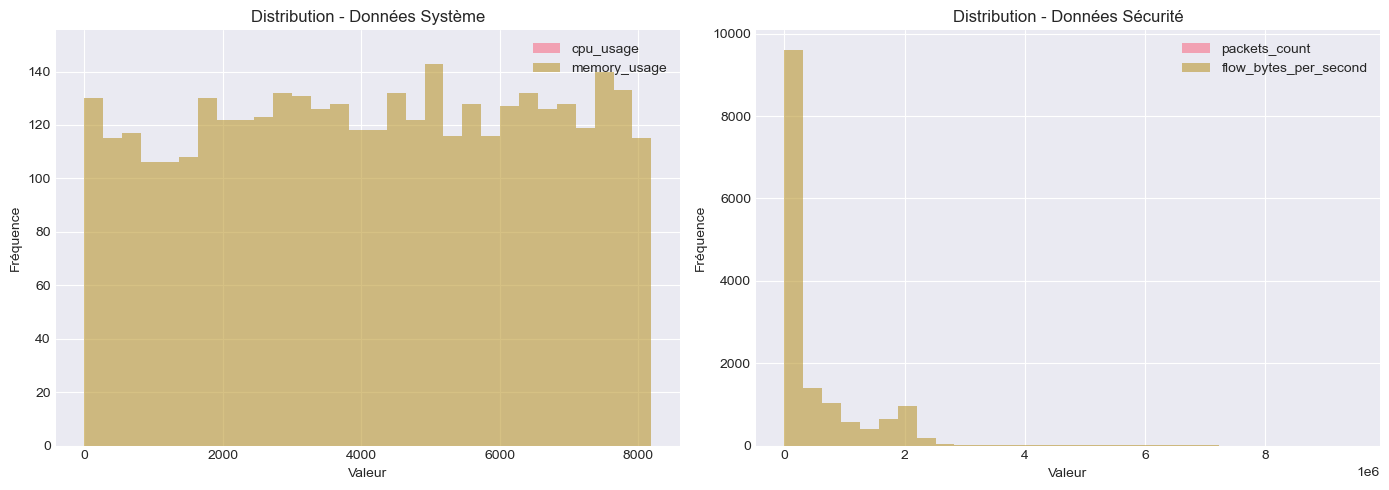

In [7]:
# %% [markdown]
# ## 12. Analyse du Problème de Fusion

# %%
print("🔧 ANALYSE DU PROBLÈME DE FUSION DES DONNÉES")
print("=" * 50)

# Séparer les deux types de données
df_system = df_hybrid[df_hybrid['anomaly_type'] == 'system_anomaly'].copy()
df_security = df_hybrid[df_hybrid['anomaly_type'] == 'security_attack'].copy()

print(f"\n📊 DATASET SYSTÈME (anomalies K8s):")
print(f"  - Lignes: {len(df_system):,}")
print(f"  - Anomalies: {df_system['label'].sum():,} ({(df_system['label'].mean()*100):.1f}%)")
print(f"  - Colonnes avec données: cpu_usage, memory_usage")

print(f"\n🛡️ DATASET SÉCURITÉ (attaques réseau):")
print(f"  - Lignes: {len(df_security):,}")
print(f"  - Attaques: {df_security['label'].sum():,} ({(df_security['label'].mean()*100):.1f}%)")
print(f"  - Colonnes avec données: packets_count, flow_bytes_per_second, etc.")

print(f"\n⚠️ PROBLÈME IDENTIFIÉ:")
print("  Les datasets système et sécurité ont des colonnes différentes")
print("  Solution pour Spark: Traiter séparément ou créer des features communes")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution des valeurs par type
system_cols = ['cpu_usage', 'memory_usage']
security_cols = ['packets_count', 'flow_bytes_per_second']

for col in system_cols:
    if col in df_system.columns:
        axes[0].hist(df_system[col].dropna(), alpha=0.6, label=col, bins=30)
axes[0].set_title('Distribution - Données Système')
axes[0].set_xlabel('Valeur')
axes[0].set_ylabel('Fréquence')
axes[0].legend()

for col in security_cols[:2]:  # Prendre 2 colonnes seulement
    if col in df_security.columns:
        axes[1].hist(df_security[col].dropna(), alpha=0.6, label=col, bins=30)
axes[1].set_title('Distribution - Données Sécurité')
axes[1].set_xlabel('Valeur')
axes[1].set_ylabel('Fréquence')
axes[1].legend()

plt.tight_layout()
plt.show()

In [8]:
# %% [markdown]
# ## 14. Améliorations Finales du Dataset

# %%
print("✨ AJOUT DES AMÉLIORATIONS FINALES")
print("=" * 40)

# Copie pour modifications
df_enhanced = df_hybrid.copy()

# 1. Ajouter timestamp réaliste
print("1. ⏰ Ajout du timestamp...")
df_enhanced['timestamp'] = pd.date_range(
    start='2024-01-01', 
    periods=len(df_enhanced), 
    freq='5min'  # Une entrée toutes les 5 minutes
)
print(f"   ✓ Timestamp ajouté: {df_enhanced['timestamp'].min()} à {df_enhanced['timestamp'].max()}")

# 2. Ajouter serveurs virtuels
print("2. 🖥️  Ajout des serveurs virtuels...")
servers = [f'server-{i:02d}' for i in range(1, 11)]  # server-01 à server-10
df_enhanced['server_name'] = np.random.choice(servers, len(df_enhanced))
print(f"   ✓ {len(servers)} serveurs ajoutés")
print(f"   Distribution: {df_enhanced['server_name'].value_counts().to_dict()}")

# 3. Ajouter data center
print("3. 🌍 Ajout des data centers...")
data_centers = ['dc-paris-01', 'dc-london-01', 'dc-frankfurt-01', 'dc-amsterdam-01']
df_enhanced['data_center'] = np.random.choice(data_centers, len(df_enhanced))
print(f"   ✓ {len(data_centers)} data centers ajoutés")

# 4. Séparer et sauvegarder versions propres
print("4. 💾 Sauvegarde des datasets améliorés...")

# Dataset système amélioré
df_system_enhanced = df_system.copy()
df_system_enhanced['timestamp'] = pd.date_range(
    start='2024-01-01', 
    periods=len(df_system_enhanced), 
    freq='10min'
)
df_system_enhanced['server_name'] = np.random.choice(servers, len(df_system_enhanced))
df_system_enhanced['data_center'] = np.random.choice(data_centers, len(df_system_enhanced))

# Dataset sécurité amélioré
df_security_enhanced = df_security.copy()
df_security_enhanced['timestamp'] = pd.date_range(
    start='2024-01-01', 
    periods=len(df_security_enhanced), 
    freq='2min'
)
df_security_enhanced['server_name'] = np.random.choice(servers, len(df_security_enhanced))
df_security_enhanced['data_center'] = np.random.choice(data_centers, len(df_security_enhanced))

# Sauvegarder
enhanced_path = "data/processed/enhanced/hybrid_dataset_enhanced.csv"
Path("data/processed/enhanced").mkdir(parents=True, exist_ok=True)

df_enhanced.to_csv(enhanced_path, index=False)
df_system_enhanced.to_csv("data/processed/enhanced/system_dataset_enhanced.csv", index=False)
df_security_enhanced.to_csv("data/processed/enhanced/security_dataset_enhanced.csv", index=False)

print(f"   ✓ Dataset hybride amélioré: {enhanced_path}")
print(f"   ✓ Dataset système amélioré: {len(df_system_enhanced):,} lignes")
print(f"   ✓ Dataset sécurité amélioré: {len(df_security_enhanced):,} lignes")

# 5. Aperçu
print("\n🔍 APERÇU DU DATASET AMÉLIORÉ:")
print(df_enhanced[['timestamp', 'server_name', 'data_center', 'anomaly_type', 'label']].head())

print("\n🎉 AMÉLIORATIONS TERMINÉES !")

✨ AJOUT DES AMÉLIORATIONS FINALES
1. ⏰ Ajout du timestamp...
   ✓ Timestamp ajouté: 2024-01-01 00:00:00 à 2024-03-05 23:00:00
2. 🖥️  Ajout des serveurs virtuels...
   ✓ 10 serveurs ajoutés
   Distribution: {'server-08': 1979, 'server-10': 1913, 'server-06': 1898, 'server-02': 1891, 'server-01': 1886, 'server-05': 1875, 'server-09': 1872, 'server-03': 1838, 'server-04': 1787, 'server-07': 1770}
3. 🌍 Ajout des data centers...
   ✓ 4 data centers ajoutés
4. 💾 Sauvegarde des datasets améliorés...
   ✓ Dataset hybride amélioré: data/processed/enhanced/hybrid_dataset_enhanced.csv
   ✓ Dataset système amélioré: 3,709 lignes
   ✓ Dataset sécurité amélioré: 15,000 lignes

🔍 APERÇU DU DATASET AMÉLIORÉ:
            timestamp server_name      data_center    anomaly_type  label
0 2024-01-01 00:00:00   server-07  dc-frankfurt-01  system_anomaly      0
1 2024-01-01 00:05:00   server-09  dc-frankfurt-01  system_anomaly      0
2 2024-01-01 00:10:00   server-09      dc-paris-01  system_anomaly      0
3 

In [8]:
import pandas as pd

csv_path = r"C:/Users/PC/Documents/k8s-log-monitoring/data/processed/final_big_df.csv"

# Read only the header to get column names
cols = pd.read_csv(csv_path, nrows=0).columns.tolist()
print(f"Total columns: {len(cols)}")
for i, col in enumerate(cols[:50]):  # just preview the first 50 columns
    print(f"{i+1}: {col}")


Total columns: 870
1: dvwa__flow_id
2: dvwa__timestamp
3: dvwa__src_ip
4: dvwa__src_port
5: dvwa__dst_ip
6: dvwa__dst_port
7: dvwa__protocol
8: dvwa__duration
9: dvwa__packets_count
10: dvwa__fwd_packets_count
11: dvwa__bwd_packets_count
12: dvwa__total_payload_bytes
13: dvwa__fwd_total_payload_bytes
14: dvwa__bwd_total_payload_bytes
15: dvwa__payload_bytes_max
16: dvwa__payload_bytes_min
17: dvwa__payload_bytes_mean
18: dvwa__payload_bytes_std
19: dvwa__payload_bytes_variance
20: dvwa__payload_bytes_median
21: dvwa__payload_bytes_skewness
22: dvwa__payload_bytes_cov
23: dvwa__payload_bytes_mode
24: dvwa__fwd_payload_bytes_max
25: dvwa__fwd_payload_bytes_min
26: dvwa__fwd_payload_bytes_mean
27: dvwa__fwd_payload_bytes_std
28: dvwa__fwd_payload_bytes_variance
29: dvwa__fwd_payload_bytes_median
30: dvwa__fwd_payload_bytes_skewness
31: dvwa__fwd_payload_bytes_cov
32: dvwa__fwd_payload_bytes_mode
33: dvwa__bwd_payload_bytes_max
34: dvwa__bwd_payload_bytes_min
35: dvwa__bwd_payload_bytes_me

In [1]:
import pandas as pd

# Path to your big CSV
file_path = "C:/Users/PC/Documents/k8s-log-monitoring/data/processed/final_big_df.csv"

# Columns to keep for logs
columns_to_keep = [
    # DVWA important columns
    "dvwa__flow_id",
    "dvwa__timestamp",
    "dvwa__src_ip",
    "dvwa__src_port",
    "dvwa__dst_ip",
    "dvwa__dst_port",
    "dvwa__protocol",
    "dvwa__duration",
    "dvwa__packets_count",
    "dvwa__fwd_packets_count",
    "dvwa__bwd_packets_count",
    "dvwa__total_payload_bytes",
    "dvwa__fwd_total_payload_bytes",
    "dvwa__bwd_total_payload_bytes",
    "dvwa__label",
    "dvwa__container_cpu_usage_seconds_rate",
    "dvwa__container_memory_usage_bytes",
    "dvwa__container_network_receive_bytes_rate",
    "dvwa__container_network_transmit_bytes_rate",
    
    # BOA important columns
    "boa__flow_id",
    "boa__timestamp",
    "boa__src_ip",
    "boa__src_port",
    "boa__dst_ip",
    "boa__dst_port",
    "boa__protocol",
    "boa__duration",
    "boa__packets_count",
    "boa__fwd_packets_count",
    "boa__bwd_packets_count",
    "boa__total_payload_bytes",
    "boa__fwd_total_payload_bytes",
    "boa__bwd_total_payload_bytes",
    "boa__label",
    "boa__container_cpu_usage_seconds_rate",
    "boa__container_memory_usage_bytes",
    "boa__container_network_receive_bytes_rate",
    "boa__container_network_transmit_bytes_rate",
]

# Read only selected columns to save memory
df = pd.read_csv(file_path, usecols=columns_to_keep)

# Save the filtered CSV
output_path = "C:/Users/PC/Documents/k8s-log-monitoring/data/processed/logs_filtered.csv"
df.to_csv(output_path, index=False)

print(f"Filtered logs saved to: {output_path}")


C:\Users\PC\AppData\Local\Temp\ipykernel_13836\1975186051.py:52: DtypeWarning: Columns (0,1,2,4,6,392,393,394,396,398) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=columns_to_keep)


Filtered logs saved to: C:/Users/PC/Documents/k8s-log-monitoring/data/processed/logs_filtered.csv


In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Load your filtered dataset
file_path = "C:/Users/PC/Documents/k8s-log-monitoring/data/processed/logs_filtered.csv"
df = pd.read_csv(file_path)

# --------------------------
# 1. Identify numeric and categorical columns
# --------------------------
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# --------------------------
# 2. Impute numeric columns
# --------------------------
# Here we use the median to avoid outlier issues
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

# --------------------------
# 3. Impute categorical columns
# --------------------------
# Use the most frequent value for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

# --------------------------
# 4. Save cleaned dataset
# --------------------------
output_path = "C:/Users/PC/Documents/k8s-log-monitoring/data/processed/logs_cleaned.csv"
df.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to: {output_path}")


C:\Users\PC\AppData\Local\Temp\ipykernel_13836\602223168.py:6: DtypeWarning: Columns (0,1,2,4,6,19,20,21,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned dataset saved to: C:/Users/PC/Documents/k8s-log-monitoring/data/processed/logs_cleaned.csv
